# Кодрян М. С. 517 группа
## ПЗАД-задание: Визуализация графа [Crime](http://konect.uni-koblenz.de/networks/moreno_crime)

This bipartite network contains persons who appeared in at least one crime case as either a suspect, a victim, a witness or both a suspect and victim at the same time. A left node represents a person and a right node represents a crime. An edge between two nodes shows that the left node was involved in the crime represented by the right node.

**BACKGROUND** 

In the 1990s Rick Rosenfeld and Norm White used police records to collect data on crime in St. Louis. They began with five homicides and recorded the names of all the individuals who had been involved as victims, suspects or witnesses. They then explored the files and recorded all the other crimes in which those same individuals appeared. This snowball process was continued until they had data on 557 crime events. Those events involved 870 participants of which: 569 appeared as victims 682 appeared as suspects 195 appeared as witnesses, and 41 were dual (they were recorded both as victims and suspects in the same crime). Their data appear, then, as an 870 by 557, individual by crime event matrix. Victims are coded as 1, suspects as 2, witnesses as 3 and duals as 4.
In addition Rosenfeld and White recorded the sex of each individual.

## Basic visualization

In [1]:
person_sex = []
with open("../data/ent.moreno_crime_crime.person.sex") as f:
    for l in f.readlines():
        person_sex.append('M' if '1' in l else 'F')

In [2]:
import re
person_name = []
with open("../data/ent.moreno_crime_crime.person.name") as f:
    for l in f.readlines():
        person_name.append(' '.join(re.findall('[A-Z][^A-Z]*', l.strip())))

In [3]:
edge_inds = []

with open("../data/moreno_crime_graph_adj_final") as f:
    for l in f.readlines():
        edge_inds.append(tuple(l.strip().split()))

person_crime = dict()
with open("../data/rel.moreno_crime_crime.person.role") as f:
    for i, l in enumerate(f.readlines()):
        person_crime[edge_inds[i]] = l.strip()

In [4]:
import plotly.plotly as py
import plotly.graph_objs as go

import matplotlib.pyplot as plt
%matplotlib inline

import networkx as nx

In [5]:
G = nx.read_adjlist("../data/moreno_crime_graph_adj_final")

In [6]:
person_nodes = [node for node in G.nodes if node.startswith('p')]
crime_nodes = [node for node in G.nodes if node.startswith('c')]
pos = nx.bipartite_layout(G, person_nodes, align='horizontal')

In [7]:
for sex, name, node in zip(person_sex, person_name, person_nodes):
    G.nodes[node]["Name"] = name
    G.nodes[node]["Sex"] = sex

In [8]:
for p, c in edge_inds:
    role = person_crime[(p, c)]
    G.edges[p, c]["Role"] = role

In [9]:
role_color = {"Victim": "green", "Suspect": "red", "Witness": "blue", "Victim Suspect": "orange"}

def get_edge_trace_role(role, color):
    edge_trace = go.Scatter(
        x=[],
        y=[],
        line=dict(width=0.5, color=color),
        hoverinfo='none',
        name=role,
        mode='lines')
    for p, c, data in G.edges(data=True):
        if data["Role"] == role:
            x0, y0 = pos[p]
            x1, y1 = pos[c]
            edge_trace['x'] += tuple([x0, x1, None])
            edge_trace['y'] += tuple([y0, y1, None])
    return edge_trace

edge_traces = [get_edge_trace_role(role, color) for role, color in role_color.items()]

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    name="Nodes",
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

In [10]:
for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color'] += tuple([len(adjacencies[1])])
    node_info = '# of connections: ' + str(len(adjacencies[1])) + '<br>Type: '
    p = adjacencies[0]
    if p in person_nodes:
        node_info += 'Person<br>Name: {0}'.format(G.nodes[p]["Name"]) + '<br>Sex: {0}'.format(G.nodes[p]["Sex"])
    else:
        node_info += 'Crime'
    node_trace['text'] += tuple([node_info])

In [11]:
fig = go.Figure(data=edge_traces + [node_trace],
             layout=go.Layout(
                title='<br>Crime network graph',
                titlefont=dict(size=16),
                showlegend=True,
                legend=dict(x=-.15, y=0.9),
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                # annotations=[ dict(
                #     text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
                #     showarrow=False,
                #     xref="paper", yref="paper",
                #     x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='crime_graph')

## Some stats

In [12]:
import numpy as np
import plotly.figure_factory as ff

In [13]:
degree_sequence_person = np.array([d for n, d in G.degree() if n in person_nodes])
degree_sequence_crime = np.array([d for n, d in G.degree() if n in crime_nodes])

hist_deg_person = go.Histogram(x=degree_sequence_person,
                               histnorm='probability',
                               name="Person")

hist_deg_crime = go.Histogram(x=degree_sequence_crime,
                              histnorm='probability',
                              name="Crime")

data = [hist_deg_person, hist_deg_crime]
layout = go.Layout(title='<br>Degree distribution histogram',
                   xaxis=dict(title="Degree"),
                   yaxis=dict(title="Frequency"))

fig = go.Figure(data, layout)

py.iplot(fig, filename='crime_deg_hist')

In [14]:
x, y = np.unique(degree_sequence_person, return_counts=True)
trace_per = go.Scatter(
    x=x, y=y,
    name="Person",
    mode='lines+markers'
)

x, y = np.unique(degree_sequence_crime, return_counts=True)
trace_cr = go.Scatter(
    x=x, y=y,
    name="Crime",
    mode='lines+markers'
)

data = [trace_per, trace_cr]
layout = go.Layout(title='<br>Degree distribution',
                   xaxis=dict(title="Degree", type='log'),
                   yaxis=dict(title="Frequency", type='log'))

fig = go.Figure(data, layout)

py.iplot(fig, filename='crime_deg_dist')

In [15]:
components = np.array([g for g in nx.connected_component_subgraphs(G)])
components = components[np.argsort([len(g) for g in components])[::-1]]

data = [go.Scatter(
            x=np.arange(1, components.size + 1),
            y=[len(g) for g in components],
            mode='lines+markers'
    )]
layout = go.Layout(title='<br>Connected components',
                   xaxis=dict(title="Component"),
                   yaxis=dict(title="Size"))

fig = go.Figure(data, layout)

py.iplot(fig, filename='crime_con_comp')

In [16]:
data = [go.Scatter(
            x=np.arange(1, components.size + 1),
            y=[nx.radius(g) for g in components],
            mode='lines+markers',
            name="Radius"
    ), go.Scatter(
            x=np.arange(1, components.size + 1),
            y=[nx.diameter(g) for g in components],
            mode='lines+markers',
            name="Diameter"
    )]
layout = go.Layout(title='<br>Connected components',
                   xaxis=dict(title="Component"),
                   yaxis=dict(title="Size"))

fig = go.Figure(data, layout)

py.iplot(fig, filename='crime_con_comp2')

In [17]:
pathlengths = []

for v in G.nodes():
    spl = dict(nx.single_source_shortest_path_length(G, v))
    for p in spl:
        pathlengths.append(spl[p])

print("Average shortest path length: ", np.mean(pathlengths))

Average shortest path length:  12.935155195174433


In [18]:
# Histogram of path lengths
hist_pl = go.Histogram(x=pathlengths, nbinsx=50, histnorm='probability')

data = [hist_pl]
layout = go.Layout(title='<br>Path lengths distribution histogram',
                   xaxis=dict(title="Length"),
                   yaxis=dict(title="Frequency"))

fig = go.Figure(data, layout)

py.iplot(fig, filename='crime_pl_hist')

C:\Users\Bourdon\Anaconda3\lib\site-packages\plotly\plotly\plotly.py:230: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



In [19]:
print("Graph's density: ", nx.density(G))

Graph's density:  0.0015512185894000063


In [20]:
data = [go.Histogram(x=nx.adjacency_spectrum(G).real, autobinx=True, histnorm='probability', name="A"),
        go.Histogram(x=nx.laplacian_spectrum(G), autobinx=True, histnorm='probability', name="L")]
layout = go.Layout(title='<br>Spectrum histograms',
                   xaxis=dict(title="Eigenvalue"),
                   yaxis=dict(title="Frequency"))

fig = go.Figure(data, layout)

py.iplot(fig, filename='crime_spectr_hist')

## Let's finally look at the most popular persons

In [21]:
person_nodes = np.array(person_nodes)
top10 = np.argsort(np.array([G.degree[p] for p in person_nodes]))[-10:][::-1]
top10_pn = person_nodes[top10]

In [22]:
persons = [G.nodes[p]["Name"] + ' ({})'.format(G.nodes[p]["Sex"]) for p in top10_pn]

data = [go.Bar(
    x=persons,
    y=[len([u for u, v, d in G.edges(p, data=True) if d["Role"] == role]) for p in top10_pn],
    name=role,
    marker=dict(color=color)
) for role, color in role_color.items()]

layout = go.Layout(title='<br>Top 10 persons',
          barmode='group')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='crimes_top10')

### Visualize

In [23]:
G_top = G.subgraph(list(top10_pn) + [v for p in top10_pn for u, v in G.edges(p)])
pos = nx.bipartite_layout(G_top, top10_pn, align='horizontal')

In [24]:
role_color = {"Victim": "green", "Suspect": "red", "Witness": "blue", "Victim Suspect": "orange"}

def get_edge_trace_role(role, color):
    edge_trace = go.Scatter(
        x=[],
        y=[],
        line=dict(width=0.5, color=color),
        hoverinfo='none',
        name=role,
        mode='lines')
    for p, c, data in G_top.edges(data=True):
        if data["Role"] == role:
            x0, y0 = pos[p]
            x1, y1 = pos[c]
            edge_trace['x'] += tuple([x0, x1, None])
            edge_trace['y'] += tuple([y0, y1, None])
    return edge_trace

edge_traces = [get_edge_trace_role(role, color) for role, color in role_color.items()]

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    name="Nodes",
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in G_top.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

In [25]:
for node, adjacencies in enumerate(G_top.adjacency()):
    node_trace['marker']['color'] += tuple([len(adjacencies[1])])
    node_info = '# of connections: ' + str(len(adjacencies[1])) + '<br>Type: '
    p = adjacencies[0]
    if p in person_nodes:
        node_info += 'Person<br>Name: {0}'.format(G_top.nodes[p]["Name"]) + '<br>Sex: {0}'.format(G_top.nodes[p]["Sex"])
    else:
        node_info += 'Crime'
    node_trace['text'] += tuple([node_info])

In [26]:
fig = go.Figure(data=edge_traces + [node_trace],
             layout=go.Layout(
                title='<br>Crime network graph (top 10 persons)',
                titlefont=dict(size=16),
                showlegend=True,
                legend=dict(x=-.15, y=0.9),
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                # annotations=[ dict(
                #     text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
                #     showarrow=False,
                #     xref="paper", yref="paper",
                #     x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='crime_graph_top')

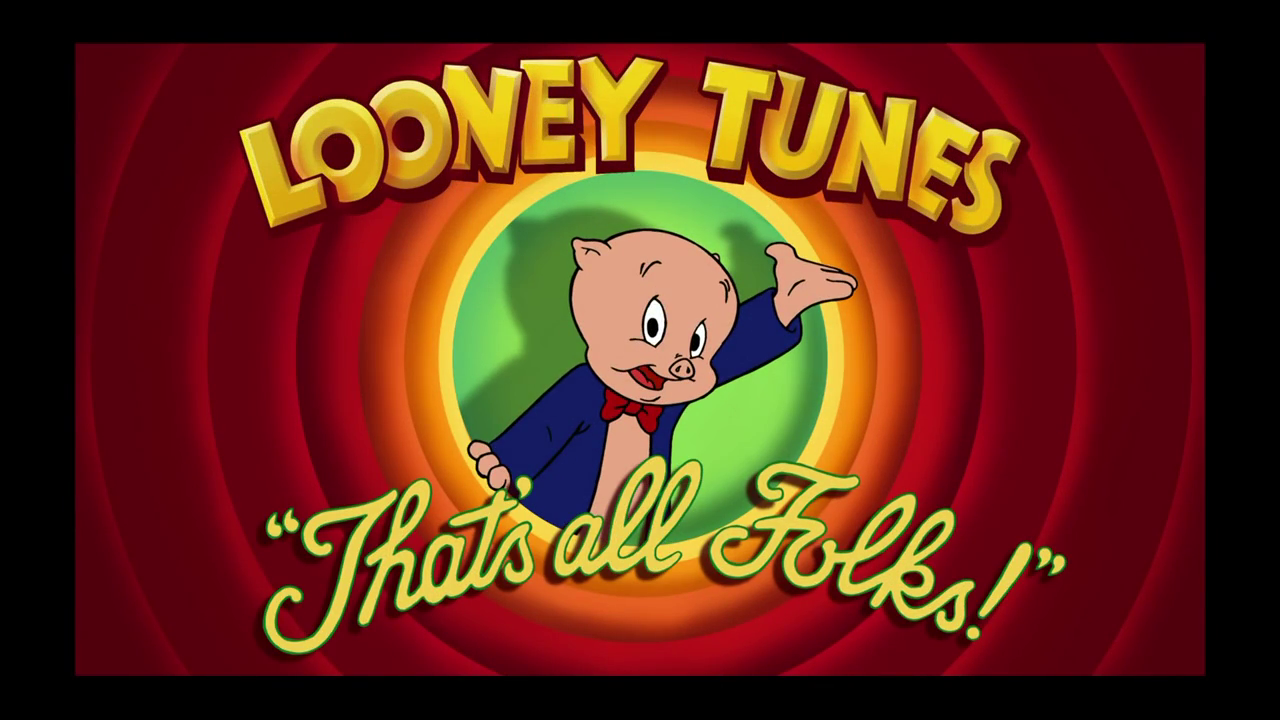